# STAROSTNE SKUPINE ZA DRŽAVE SVETA

Delo na data setu POPULATION_BY_AGE_BOTH_SEXES.   


## Priprava podatkov

In [1]:
import pandas as pandas
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets      import Dropdown
from bqplot          import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet      import Map, GeoJSON, WidgetControl
from ipywidgets import IntSlider, ColorPicker, jslink

#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
"""warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')"""
%matplotlib inline

rows_to_skip = [i for i in range(0, 16)]  
rows_to_skip.extend([i for i in range(17, 272)])   # odstranjevanje vrstic ki bi delale probleme
rows_to_skip.extend([i for i in range(362, 377)])
names  =["Region-Country", "Date", "0-4", "5-9",  "10-14", "15-19", "20-24", "25-29", 
         "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",  "60-64", "65-69", "70-74", "75-79",
         "80-84", "85-89", "90-94", "95-99", "100+"]

main_set = pandas.read_excel('../podatki/POPULATION_BY_AGE_BOTH_SEXES.xlsx', 
                             usecols=(2, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28),
                                skiprows=rows_to_skip,
                                names=names)
main_set["population_sum"] = np.NaN
main_set["avg_age"] = np.NaN

for index, row in main_set.iterrows():
    temp_sum = 0
    for num_range, num in row[2:-2].iteritems():
        temp_sum += num

    main_set.loc[index,"population_sum"] = float(temp_sum)

    pop_age = 0        # mogoče zamenji z mediano 
    age_range = 2
    for num_range, num in row[2:-2].iteritems():
        pop_age += (num / temp_sum) * age_range
        age_range += 5
    main_set.loc[index,"avg_age"] = float(pop_age)

In [2]:
#main_set

Pripravil sem si podatke tako, da sem odstranil vrstice in stolpce katerih nisem potreboval ter nastavil header.

Funkcija za dobit skupno populacijo države za dano leto :

In [3]:
def drawBarChart(year_and_pop_ar, country):
    fig=plt.figure(figsize=(10, 8), dpi= 100, facecolor='w')
    plt.bar([i[0] for i in year_and_pop_ar], [i[1] for i in year_and_pop_ar], 
            color='royalblue', alpha=0.7, width=3)
    #plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.xlabel('Years')
    plt.ylabel('Number in thousands')
    plt.title(country + ' population growth graph')
    plt.show()
    
def drawScatter(year_and_pop_ar, country):
    fig=plt.figure(figsize=(10, 8), dpi= 100, facecolor='w')
    date_arr  = [i[0] for i in year_and_pop_ar]
    pop_arr = [i[1] for i in year_and_pop_ar]
    max_pop = max(pop_arr)
    step = int(math.ceil(max_pop / 1000.0)) * 1000 / 10

    plt.plot(date_arr, pop_arr)
    plt.scatter(date_arr, pop_arr, color=(0.1, 0.9, 1, 0.90))
    plt.yticks(np.arange(0,  max_pop + step*2, step))
    plt.xlabel('Years')
    plt.ylabel('Number in thousands')
    plt.title(country + ' population growth graph')
    plt.show()
    
def getSumPopulationArray(country):
    year_pop_array = []
    
    for date in range(1960, 2021, 5):
        pop = float(main_set[(main_set['Region-Country'] == country) & (main_set["Date"] == date)]["population_sum"].values)
        year_pop_array.append((date, pop))
    return year_pop_array 

Tukaj lahko vidimo rast populacije za dano državo skozi leta.

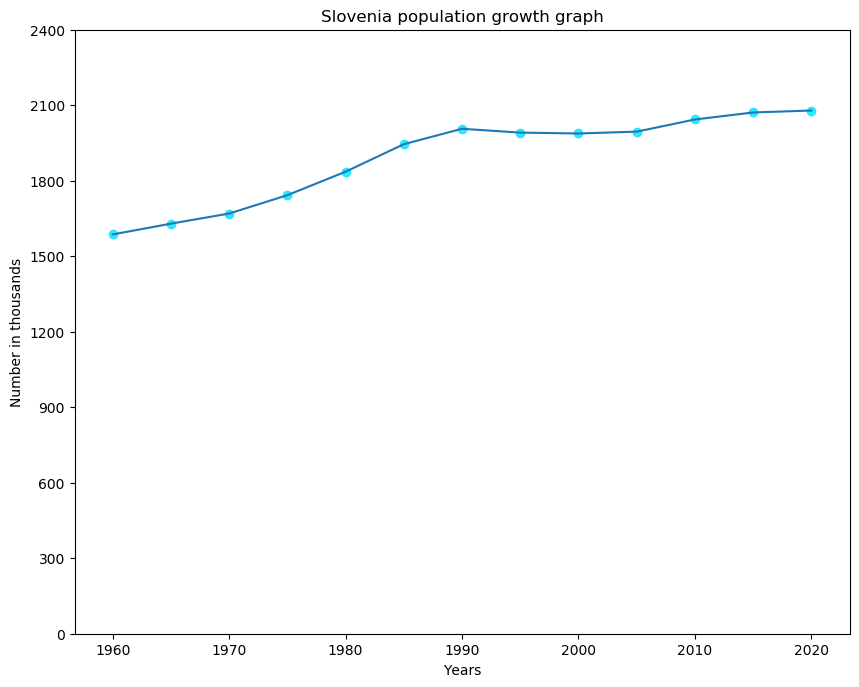

In [4]:
country = "Slovenia"
country_pop = getSumPopulationArray(country)
drawScatter(country_pop, country)

Grafi starostne razporeditve dane države v enem letu.

In [5]:
def myround(x, base=5):
    return base * round(x/base)

def getAgeDistribution(country, date):  # works only for multiples of 5, from 1950 - 2020
        date = myround(date)
        distribution_array = []
        country_pop = main_set[(main_set['Region-Country'] == country) & (main_set["Date"] == date)]
        temp_sum = country_pop.iloc[:, 2:-2]
        # print(temp_sum)
        for age, value in temp_sum.iteritems():
            distribution_array.append((age, value.iloc[0]))

        return distribution_array

def drawBarChartDistribution(year_and_pop_ar, country):
    fig=plt.figure(figsize=(10, 8), dpi= 100, facecolor='w')
    plt.barh([i[0] for i in year_and_pop_ar], [i[1] for i in year_and_pop_ar], 
            color='royalblue', alpha=0.7)
    #plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.xlabel('Number in thousands')
    plt.ylabel('Years')
    plt.title(country + ' population age distribution')
    plt.savefig('Japan.png')
    plt.show()

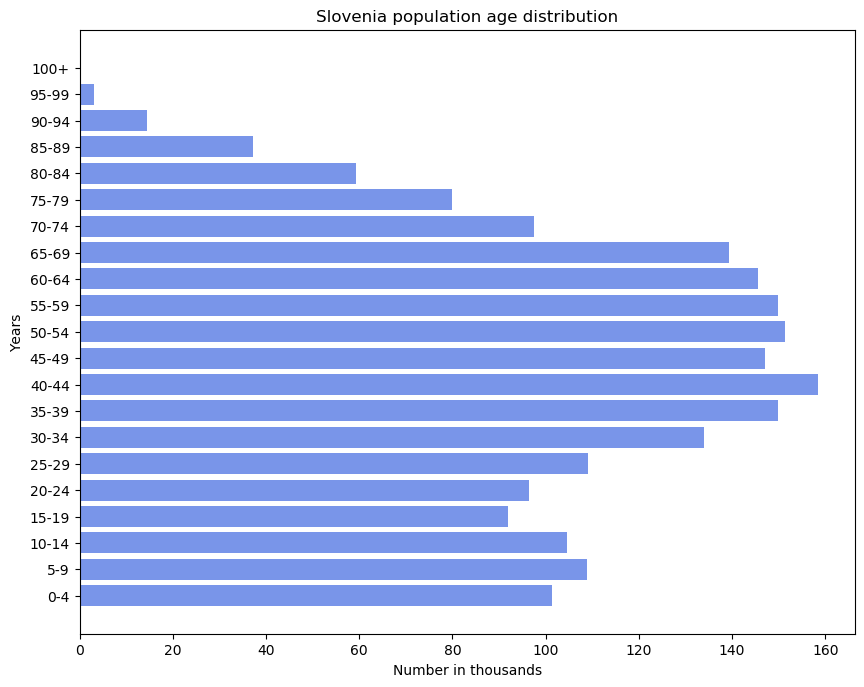

In [6]:
work = getAgeDistribution(country, 2020)
drawBarChartDistribution(work, country)

Omogočen izpis držav z največjo in najmanjšo povprečno starostjo. Kmalu bo vključena tudi mediana.

In [7]:
only_2020_data = main_set.copy()

In [8]:
for index, row in only_2020_data.iterrows():
    if row[1] != 2020:
        only_2020_data = only_2020_data.drop(index)
 
only_2020_data = only_2020_data.sort_values(by=["avg_age"])
only_2020_data.nlargest(20, "avg_age")

,Region-Country,Date,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+,population_sum,avg_age
1709,Japan,2020,4778.481,5401.488,5564.526,5702.645,5996.877,6150.448,6789.745,7665.671,...,8379.113,9127.318,7058.057,5339.049,3630.344,1785.823,517.525,78.636,126476.458,46.952638
3284,Italy,2020,2324.694,2670.301,2857.357,2876.091,2942.506,3160.930,3365.512,3632.922,...,3531.295,3391.798,2637.110,2302.393,1397.261,639.739,172.639,16.517,60461.828,45.305040
3344,Portugal,2020,400.652,440.424,489.999,525.167,539.834,533.864,560.997,654.312,...,621.305,566.943,451.371,352.212,224.130,84.924,19.175,1.961,10196.707,44.645591
3269,Greece,2020,409.459,471.668,542.237,526.618,529.416,527.800,597.812,738.703,...,580.634,549.464,406.619,394.392,260.756,104.969,23.197,2.681,10423.056,44.401792
3464,Germany,2020,4058.679,3822.225,3811.645,4118.971,4553.436,4823.925,5441.865,5430.155,...,4823.439,3833.823,3637.591,3259.094,1635.049,758.147,204.159,19.295,83783.945,44.028523
3209,Southern Europe,2020,6305.534,7084.710,7713.512,7521.029,7778.283,8167.915,8838.587,9998.977,...,8698.351,7869.520,6085.987,4936.143,3213.505,1394.785,341.276,35.143,152215.243,44.009181
3389,Spain,2020,1990.096,2244.391,2497.954,2238.123,2255.909,2361.690,2618.972,3283.021,...,2401.343,2204.150,1811.156,1288.336,1039.117,471.255,112.050,13.083,46754.783,43.543439
2129,Martinique,2020,18.353,17.600,22.799,24.323,24.395,16.977,16.928,17.174,...,24.156,19.568,14.104,11.245,7.638,3.361,1.116,0.235,375.265,43.505110
1649,"China, Hong Kong SAR",2020,362.563,301.632,285.856,266.803,374.346,493.283,536.342,585.823,...,459.791,344.127,180.957,177.823,119.620,59.859,18.476,3.561,7496.988,43.501992
2894,Bulgaria,2020,312.730,336.652,370.613,315.268,299.467,390.450,480.839,476.752,...,455.294,424.600,285.768,191.839,101.275,28.222,4.510,0.179,6948.445,43.361899


## Deaths and causes

In [9]:
"""columns_mortality = ["Country","Year","Cause","Sex","Frmat",
                    "IM_Frmat","Deaths1","Deaths2","Deaths3","Deaths4","Deaths5",
                    "Deaths6","Deaths7","Deaths8","Deaths9","Deaths10","Deaths11",
                    "Deaths12","Deaths13","Deaths14","Deaths15","Deaths16","Deaths17",
                    "Deaths18","Deaths19","Deaths20","Deaths21","Deaths22","Deaths23",
                    "Deaths24","Deaths25","Deaths26","IM_Deaths1","IM_Deaths2","IM_Deaths3",
                    "IM_Deaths4"]

temp_set_1 = pandas.read_csv('../podatki/death_data/Morticd10_part1', usecols=columns_mortality, low_memory=False)
temp_set_2 = pandas.read_csv('../podatki/death_data/Morticd10_part2', usecols=columns_mortality, low_memory=False)

frames = [temp_set_1, temp_set_2]
mortality_data_set = pandas.concat(frames)

countries_dict = {}
with open("../podatki/death_data/country_codes") as file:
    first_line = file.readline()
    for line in file:
        arr_all = line.strip().split(",")
        countries_dict[int(arr_all[0])] = arr_all[1]# fix thing
        
mortality_data_set['Country'] = mortality_data_set['Country'].map(countries_dict)

"Country","Admin1","SubDiv","Year","List","Cause,Sex","Frmat",
                    "IM_Frmat","Deaths1","Deaths2","Deaths3","Deaths4","Deaths5",
                    "Deaths6","Deaths7","Deaths8","Deaths9","Deaths10","Deaths11",
                    "Deaths12","Deaths13","Deaths14","Deaths15","Deaths16","Deaths17",
                    "Deaths18","Deaths19","Deaths20","Deaths21","Deaths22","Deaths23",
                    "Deaths24","Deaths25","Deaths26","IM_Deaths1","IM_Deaths2","IM_Deaths3",
                    "IM_Deaths4"

mortality_data_set["allInfantDeaths"] = None
for index, row in mortality_data_set.iterrows():
    temp_arr = [row["IM_Deaths1"], row["IM_Deaths2"], row["IM_Deaths3"], row["IM_Deaths4"]]
    sum = np.nansum(temp_arr)
    mortality_data_set.loc[index, "allInfantDeaths"] = sum
    break
;
mortality_data_set""";

In [10]:
"""country_data = mortality_data_set.loc[mortality_data_set["Country"] == "Germany"]
country_year_data = country_data.groupby(["Year", "Country", "Sex"]).sum() # .agg(lambda x: x.tolist())
country_year_data""";

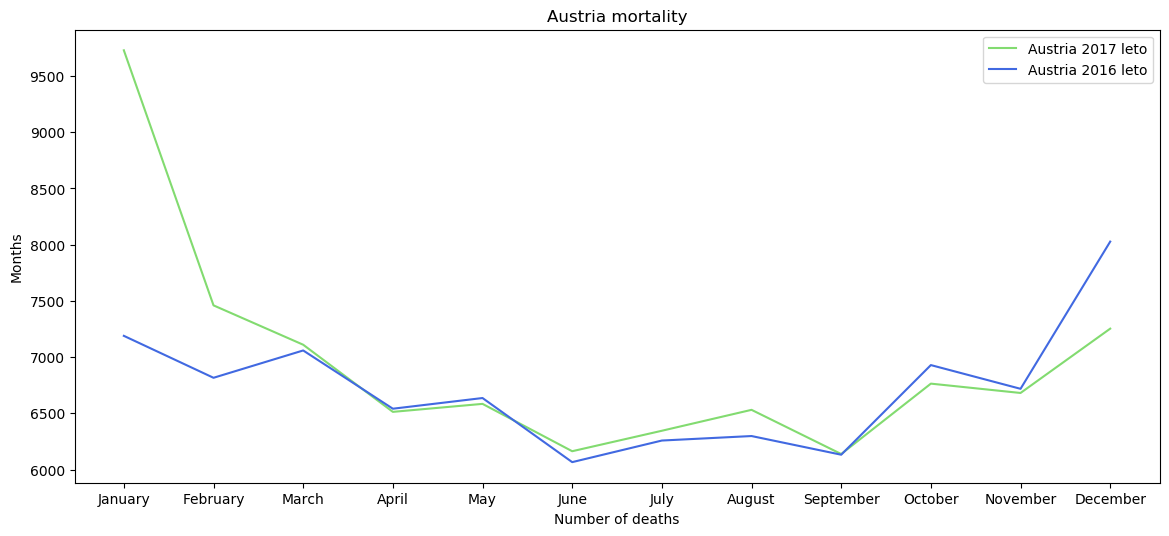

In [11]:
# nov data set
country_cur = "Austria"
year_cur_1 = "2017"
year_cur_2 = "2016"

def death_count_country_year(country, year):
    col_names = ["Country", "Year", "Area", "Month", "Record Type", "Reliability", "Source Year", "Value", "Value Footnotes"]
    deaths_data = pandas.read_csv('../podatki/unData_deaths_per_month.txt', sep=";", header=0, names=col_names)

    country_data = deaths_data.loc[(deaths_data["Country"] == country) & (deaths_data["Year"] == year)]
    month_death_dict = dict()

    for idx, row in country_data.iterrows():
        if row["Month"] != "Total":
            month_death_dict[row["Month"]] = row["Value"]

    return month_death_dict


def drawBarChartMortality(year1, year2, country): 
    year1 = str(year1)
    year2 = str(year2)
    month_num_dict_1 = death_count_country_year(country, year1)
    month_num_dict_2 = death_count_country_year(country, year2)
    x_ticks_1 = sorted(month_num_dict_1.keys())
    x_ticks_2 = sorted(month_num_dict_2.keys())
    
    if x_ticks_1 == x_ticks_2:        
        fig = plt.figure(figsize=(14, 6), dpi= 100, facecolor='w')
    
        plt.plot(list(month_num_dict_1.keys()), list(month_num_dict_1.values()), color=(0.3, 0.8, 0.2, 0.70),
                label=(country + " " + str(year1) + " leto"))
        plt.plot(list(month_num_dict_2.keys()), list(month_num_dict_2.values()), color='royalblue',
                label=(country + " " + str(year2) + " leto"))         
        # plt.gcf().autofmt_xdate()
        # plt.margins(x=0)
        plt.xlabel('Number of deaths')
        plt.ylabel('Months')
        plt.title(country + ' mortality')
        plt.legend()
        plt.show()
    else:
        print("Dates do not match")
        print(x_ticks_1)
        print(x_ticks_2)
   
    
drawBarChartMortality(year_cur_1, year_cur_2, country_cur)

## Map of the world

You can choose a country by clicking on it.

In [12]:
def display_data_for_country(country, year):
    country_pop = getSumPopulationArray(country)
    drawScatter(country_pop, country)
    age_distrbution = getAgeDistribution(country, year)
    drawBarChartDistribution(age_distrbution, country)
    drawBarChartMortality(year, year-1, country)
    

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

leto 2020
Selected country: Brazil


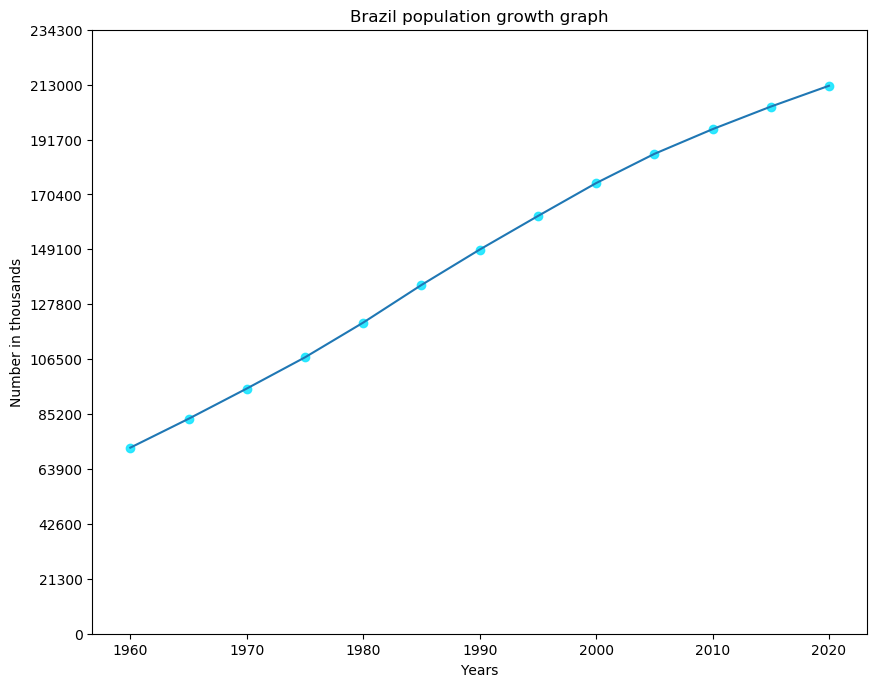

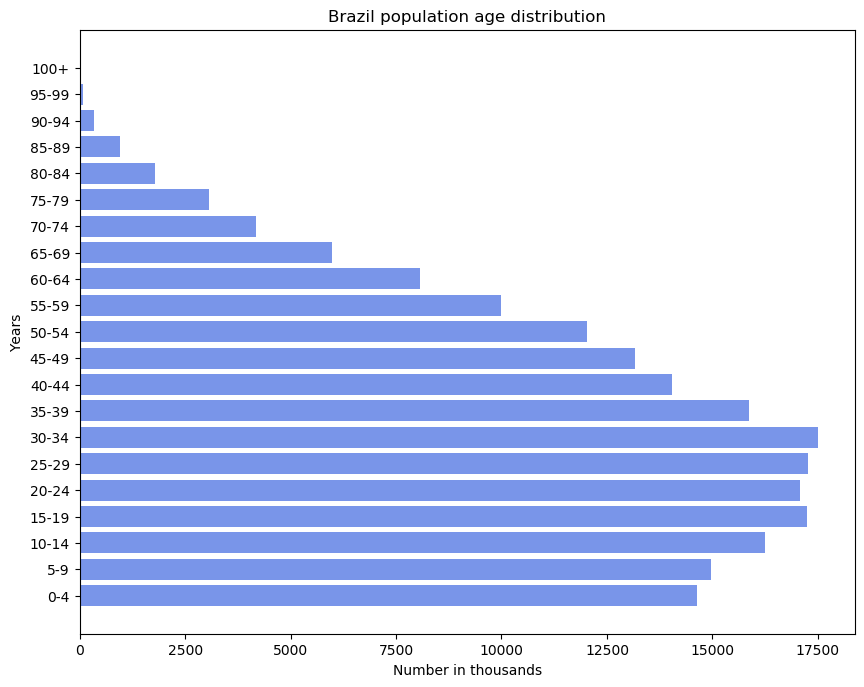

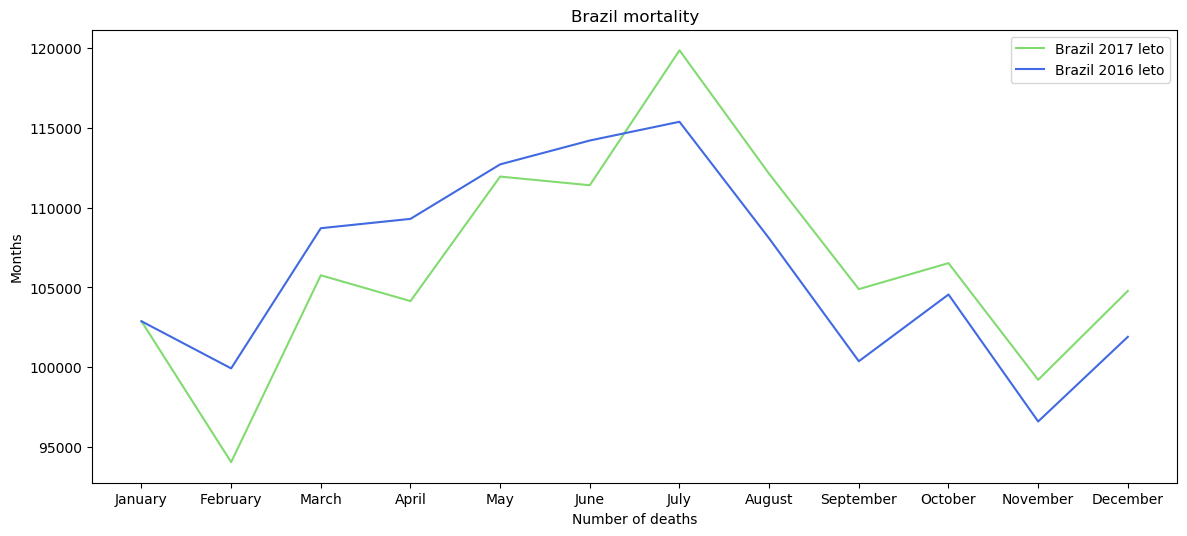

In [28]:
with open('../podatki/countries.geo.json') as f:
    countries = json.load(f)

map_year = 2017
m = Map(zoom=3)

geo = GeoJSON(data=countries, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Countries')
year_slider = IntSlider(description='Year:', min=2015, max=2020, value=2018)
widget_control1 = WidgetControl(widget=year_slider, position='topright')
m.add_control(widget_control1)



def click_handle(event=None, feature=None, **kwargs): # must be none if none is given
    if feature is not None:
        year = year_slider.value
        clear_output(True)
        display(m)
        print("leto " + str(year))
        country_name = kwargs['properties']['name']
        print("Selected country: " + country_name)
        display_data_for_country(country_name, 2017)

geo.on_click(click_handle)
m.add_layer(geo)
display(m)

In [ ]:
"""x_ticks_1 = sorted(month_num_dict_1.keys())
x_ticks_2 = sorted(month_num_dict_2.keys())
print(x_ticks_1)
print(x_ticks_2)
if x_ticks_1 == x_ticks_2:        
    fig = plt.figure(figsize=(14, 6), dpi= 100, facecolor='w')

    plt.bar(list(month_num_dict_2.keys()), list(month_num_dict_2.values()), color=(0.3, 0.8, 0.2, 0.40))
    plt.bar(list(month_num_dict_1.keys()), list(month_num_dict_1.values()), color='royalblue')

    plt.xlabel('Number of deaths')
    plt.ylabel('Months')
    plt.title(country + ' mortality')
    plt.show()
else:
    print("Dates do not match")""";
   
